In [1]:
import numpy as np 
import pandas as pd 
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision.models as models
import math

In [2]:
class PlantVillageDataset(Dataset):
    def __init__(self,image_paths,labels,transform=None):
        self.image_paths=image_paths
        self.labels=labels
        self.transform=transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self,idx):
        image_path=self.image_paths[idx]
        label=self.labels[idx]
        img=Image.open(image_path).convert('RGB')
        if self.transform:
            img=self.transform(img)
        return img,torch.tensor(label,dtype=torch.long)

In [3]:
def load_images(directory_root):
    image_list,label_list=[],[]
    print("[INFO] Loading images...")

    for disease_folder in os.listdir(directory_root):
        disease_folder_path=os.path.join(directory_root,disease_folder)
        if not os.path.isdir(disease_folder_path):
            continue
        for img_name in os.listdir(disease_folder_path):
            if img_name.startswith('.'):
                continue
            img_path = os.path.join(disease_folder_path, img_name)
            if img_path.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_list.append(img_path)
                label_list.append(disease_folder)

    print("[INFO] Image loading completed")
    print(f"Total images: {len(image_list)}")
    return image_list, label_list

In [4]:
directory_root = r"C:\Users\mmukh\OneDrive\Desktop\Major project\Data Sets\plantvillage dataset\color"
image_paths, labels = load_images(directory_root)

[INFO] Loading images...
[INFO] Image loading completed
Total images: 54305


In [5]:
label_encoder=LabelEncoder()
labels_encoded=label_encoder.fit_transform(labels)

In [6]:
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels_encoded, test_size=0.3, random_state=42, stratify=labels_encoded
)
valid_paths, test_paths, valid_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.67, random_state=42, stratify=temp_labels
)

print(f"Training samples: {len(train_paths)}")
print(f"Validation samples: {len(valid_paths)}")
print(f"Test samples: {len(test_paths)}")

Training samples: 38013
Validation samples: 5376
Test samples: 10916


In [7]:
train_transform=transforms.Compose([
    transforms.Resize([224,224]),
    transforms.RandomAffine(degrees=10,shear=0.3,scale=(0.5,1.5)),
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.ToTensor()
])

valid_test_transform=transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor()
])

In [8]:
train_dataset=PlantVillageDataset(train_paths,train_labels,transform=train_transform)
valid_dataset=PlantVillageDataset(valid_paths,valid_labels,transform=valid_test_transform)
test_dataset = PlantVillageDataset(test_paths, test_labels, transform=valid_test_transform)

In [9]:
batch_size=32
train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=False)
valid_loader=DataLoader(valid_dataset,batch_size=batch_size,shuffle=False)
test_loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

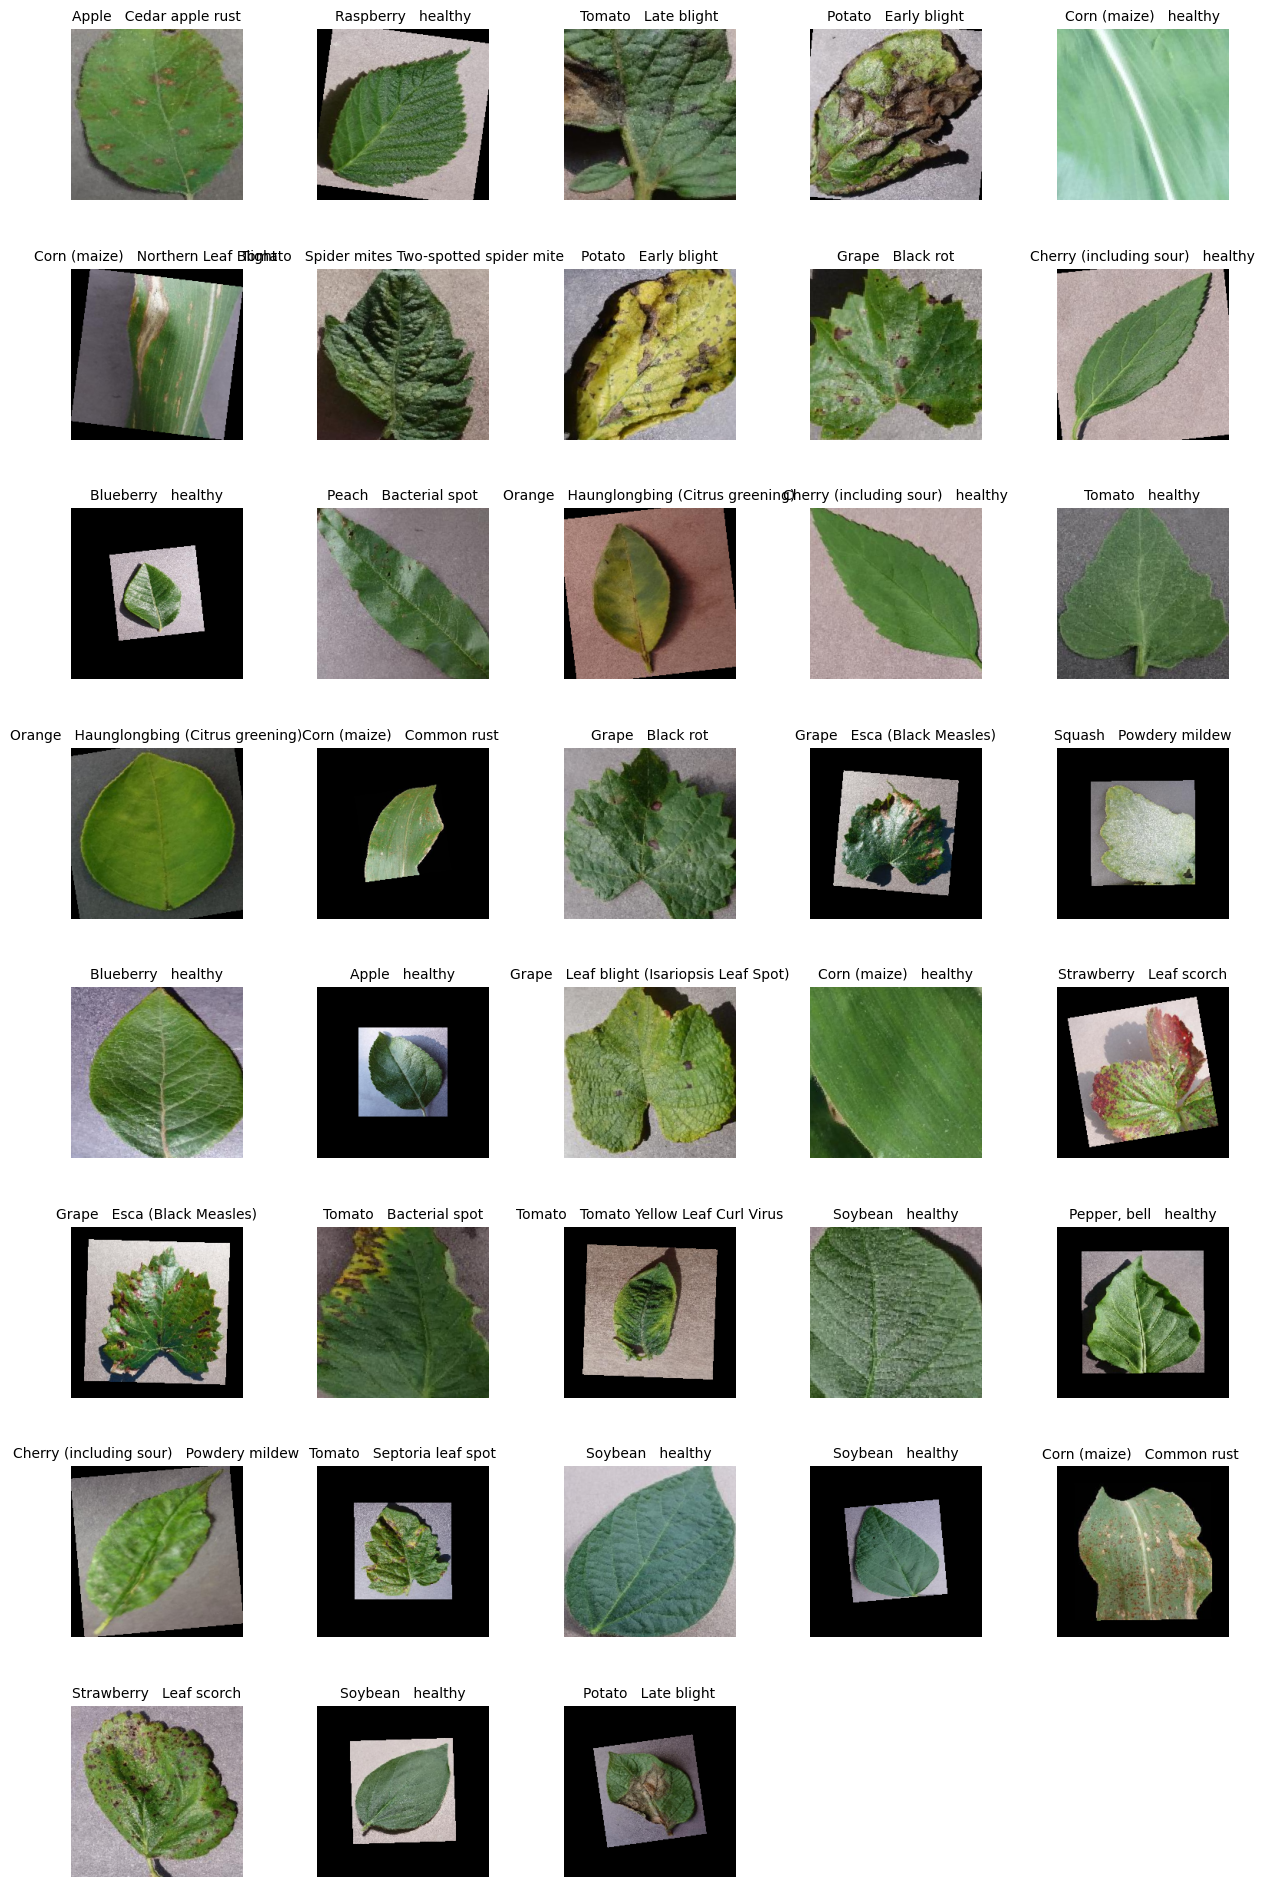

In [10]:
def visualize_samples(dataset, num_samples=38,cols=5):

    rows = math.ceil(num_samples / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    
    for i in range(num_samples):
        img, label = dataset[i]
        img = img.permute(1, 2, 0).numpy()

        
        ax = axes[i // cols, i % cols] if rows > 1 else axes[i % cols]
        ax.imshow(img)
        ax.set_title(label_encoder.inverse_transform([label])[0].replace('_', ' '), fontsize=10)
        ax.axis('off')

    for j in range(num_samples, rows * cols):
        fig.delaxes(axes.flatten()[j])

    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()
visualize_samples(train_dataset)

In [11]:
num_classes = len(label_encoder.classes_)
print(f"Number of Classes: {num_classes}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device Used: {device}")

Number of Classes: 38
Device Used: cuda


In [12]:
model=models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model=model.to(device)

In [13]:
num_features=model.fc.in_features
model.fc=nn.Sequential(
    nn.Dropout(0.01),
    nn.Linear(num_features,num_classes)
)
model.fc.to(device)

Sequential(
  (0): Dropout(p=0.01, inplace=False)
  (1): Linear(in_features=2048, out_features=38, bias=True)
)

In [14]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [15]:
from torchsummary import summary
summary(model, input_size=(3, 224, 224), device="cuda" if torch.cuda.is_available() else "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [16]:
def train_model(model,train_loader,valid_loader,criterion,optimizer,num_epochs=10):
    train_loss_history=[]
    val_loss_history=[]

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        model.train()
        running_loss=0.0
        correct,total=0,0

        for images,labels in tqdm(train_loader,desc='Training'):
            images,labels=images.to(device),labels.to(device)
            optimizer.zero_grad() #reset the gradient for training...
            outputs=model(images)
            loss=criterion(outputs,labels)
            loss.backward()
            optimizer.step()

            running_loss+=loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_loss_history.append(train_loss)

        model.eval()
        val_loss=0.0
        correct,total=0,0
        with torch.no_grad():
            for images, labels in tqdm(valid_loader, desc="Validating"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_loss /= len(valid_loader)
        val_acc = correct / total
        val_loss_history.append(val_loss)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Valid Loss: {val_loss:.4f}, Valid Acc: {val_acc:.4f}")

    return model, train_loss_history, val_loss_history        

In [17]:
num_epochs = 10
trained_model, train_loss, val_loss = train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs)

Epoch 1/10


Validating: 100%|████████████████████████████████████████████████████████████████████| 168/168 [00:32<00:00,  5.19it/s]


Train Loss: 0.3400, Train Acc: 0.8988
Valid Loss: 0.3334, Valid Acc: 0.9068
Epoch 2/10


Validating: 100%|████████████████████████████████████████████████████████████████████| 168/168 [00:27<00:00,  6.09it/s]


Train Loss: 0.1244, Train Acc: 0.9595
Valid Loss: 0.1468, Valid Acc: 0.9505
Epoch 3/10


Validating: 100%|████████████████████████████████████████████████████████████████████| 168/168 [00:27<00:00,  6.08it/s]


Train Loss: 0.0928, Train Acc: 0.9699
Valid Loss: 0.1530, Valid Acc: 0.9526
Epoch 4/10


Validating: 100%|████████████████████████████████████████████████████████████████████| 168/168 [00:27<00:00,  6.04it/s]


Train Loss: 0.0784, Train Acc: 0.9746
Valid Loss: 0.0859, Valid Acc: 0.9715
Epoch 5/10


Validating: 100%|████████████████████████████████████████████████████████████████████| 168/168 [00:27<00:00,  6.09it/s]


Train Loss: 0.0683, Train Acc: 0.9777
Valid Loss: 0.0408, Valid Acc: 0.9855
Epoch 6/10


Validating: 100%|████████████████████████████████████████████████████████████████████| 168/168 [00:27<00:00,  6.06it/s]


Train Loss: 0.0595, Train Acc: 0.9804
Valid Loss: 0.0764, Valid Acc: 0.9781
Epoch 7/10


Validating: 100%|████████████████████████████████████████████████████████████████████| 168/168 [00:27<00:00,  6.03it/s]


Train Loss: 0.0520, Train Acc: 0.9831
Valid Loss: 0.0737, Valid Acc: 0.9784
Epoch 8/10


Validating: 100%|████████████████████████████████████████████████████████████████████| 168/168 [00:30<00:00,  5.60it/s]


Train Loss: 0.0473, Train Acc: 0.9842
Valid Loss: 0.2079, Valid Acc: 0.9498
Epoch 9/10


Validating: 100%|████████████████████████████████████████████████████████████████████| 168/168 [00:28<00:00,  5.97it/s]


Train Loss: 0.0408, Train Acc: 0.9867
Valid Loss: 0.0961, Valid Acc: 0.9738
Epoch 10/10


Validating: 100%|████████████████████████████████████████████████████████████████████| 168/168 [00:30<00:00,  5.47it/s]

Train Loss: 0.0389, Train Acc: 0.9869
Valid Loss: 0.0419, Valid Acc: 0.9877


In [18]:
torch.save(trained_model.state_dict(), "plant_disease_resnet50.pth")
print("Model saved!")

Model saved!


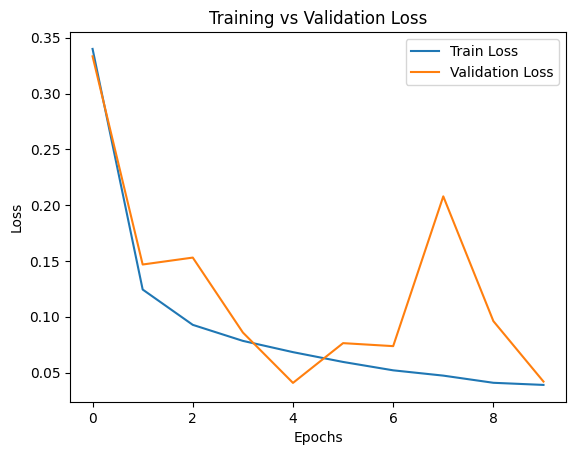

In [19]:
plt.plot(range(num_epochs), train_loss, label="Train Loss")
plt.plot(range(num_epochs), val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

In [23]:
def test_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_acc = correct / total
    print(f"Test Accuracy: {test_acc * 100:.2f}%")

test_model(trained_model, test_loader)

Testing: 100%|███████████████████████████████████████████████████████████████████████| 342/342 [00:56<00:00,  6.06it/s]

Test Accuracy: 98.88%


In [46]:
# Import all necessary libraries
import os
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder  # This is the missing import
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [47]:
# Define your dataset path
data_path = r"C:\Users\mmukh\OneDrive\Desktop\Major project\Data Sets\plantvillage dataset\color"

# Get all class names from the directory structure
class_names = sorted([
    d for d in os.listdir(data_path) 
    if os.path.isdir(os.path.join(data_path, d))
])

# Create and fit the label encoder
label_encoder = LabelEncoder()
label_encoder.fit(class_names)

print("Available classes:", list(label_encoder.classes_))

Available classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 

In [69]:
num_classes = len(label_encoder.classes_) 

model = models.resnet50(weights=None)
model.fc = nn.Sequential(
    nn.Dropout(0.01),
    nn.Linear(model.fc.in_features, num_classes)
)
model = model.to(device)

# Load the saved weights
model.load_state_dict(torch.load("plant_disease_resnet50.pth"))
model.eval()
print(f"Model successfully loaded for {num_classes} classes!")

Model successfully loaded for 38 classes!


In [71]:
def predict_single_image(image_path, model, label_encoder, transform, device, show_image=True):
    """Predict plant disease from single image"""
    try:
        img = Image.open(image_path).convert('RGB')  # Fixed: using image_path instead of r
        
        if show_image:
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(img)
            plt.title("Original Image")
            plt.axis('off')
    
        img_transformed = transform(img).unsqueeze(0).to(device)
        
        model.eval()
        with torch.no_grad():
            outputs = model(img_transformed)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            confidence, predicted = torch.max(probabilities, 1)
            
            top5_probs, top5_indices = torch.topk(probabilities, 5)
            top5_classes = label_encoder.inverse_transform(top5_indices.cpu().numpy()[0])
            top5_confidences = top5_probs.cpu().numpy()[0]
            top_predictions = list(zip(top5_classes, top5_confidences))
        
        predicted_class = label_encoder.inverse_transform(predicted.cpu().numpy())[0]
        confidence = confidence.item()
        
        if show_image:
            plt.subplot(1, 2, 2)
            plt.imshow(img_transformed.squeeze(0).permute(1, 2, 0).cpu().numpy())
            plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2%}")
            plt.axis('off')
            plt.show()
            
            print("\nTop 5 Predictions:")
            for i, (class_name, prob) in enumerate(top_predictions, 1):
                print(f"{i}. {class_name.replace('_', ' '):<30} {prob:.2%}")
        
        return predicted_class, confidence, top_predictions
    
    except Exception as e:
        print(f"Error processing image: {e}")
        return None, None, None

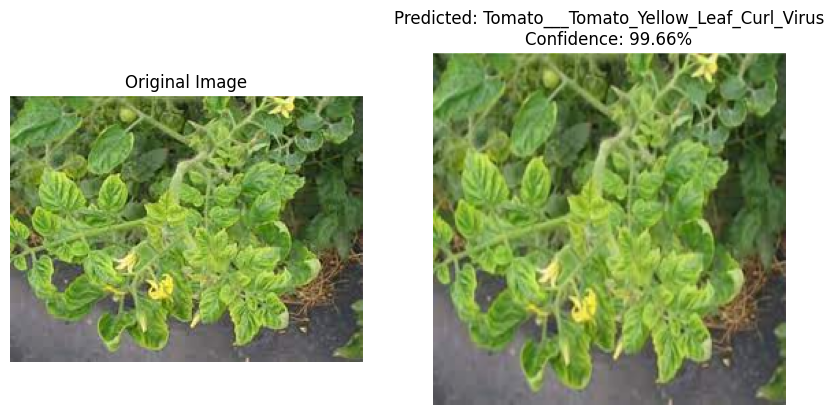


Top 5 Predictions:
1. Tomato   Tomato Yellow Leaf Curl Virus 99.66%
2. Strawberry   Leaf scorch       0.27%
3. Potato   Early blight          0.03%
4. Strawberry   healthy           0.02%
5. Grape   Esca (Black Measles)   0.01%

Final Prediction: Tomato___Tomato_Yellow_Leaf_Curl_Virus (Confidence: 99.66%)


In [72]:
test_image_path = r"C:\Users\mmukh\Downloads\images (1).jpeg"

pred_class, confidence, top_preds = predict_single_image(
    image_path=test_image_path,
    model=model,
    label_encoder=label_encoder,
    transform=valid_test_transform,
    device=device
)

if pred_class:
    print(f"\nFinal Prediction: {pred_class} (Confidence: {confidence:.2%})")
else:
    print("Prediction failed - check error message above")